# Random Forest regression

## Data loading

In [2]:
def get_station_updates(city, station):
    df = pd.read_csv('challenge_data/{}/stations/{}.csv'.format(city, station))
    df.drop_duplicates(subset='moment', inplace=True)
    df['moment'] = pd.to_datetime(df['moment'])
    return df


def get_weather_updates(city):
    df = pd.read_csv('challenge_data/{}/weather.csv'.format(city))
    df.drop_duplicates(subset='moment', inplace=True)
    df['moment'] = pd.to_datetime(df['moment'])
    return df

## Pre-processing

In [3]:
def add_temporal_features(df):
    df['weekday'] = df['moment'].map(lambda m: m.weekday())
    df['hour'] = df['moment'].map(lambda m: m.hour)
    df['minute'] = df['moment'].map(lambda m: m.minute)
    return df

    
def add_weather_updates(df, city_name):
    w_df = get_weather_updates(city)
    w_times = pd.Series(w_df['moment'].values, w_df['moment'])
    w_times.sort_values(inplace=True)
    df['moment_weather'] = w_times.reindex(df['moment'], method='nearest').values
    joined_df = pd.merge(left=df, right=w_df, left_on='moment_weather', right_on='moment', suffixes=('', '_y'))
    joined_df.drop('moment_y', 1, inplace=True)
    return joined_df


def preprocess(df):
    df = add_temporal_features(df)
    df = add_weather_updates(df, city)
    df.set_index('moment', drop=False, inplace=True)
    return df

## Temporal train-test split

In [4]:
def split_train_test(X, y, t0, t1, t2):
    X_train = X[(X.index >= t0) & (X.index < t1)].copy()
    X_test = X[(X.index >= t1) & (X.index <= t2)].copy()
    y_train = y[(X.index >= t0) & (X.index < t1)].copy()
    y_test = y[(X.index >= t1) & (X.index <= t2)].copy()
    return X_train, X_test, y_train, y_test

In [5]:
features = [
    'weekday',
    'hour',
    'minute',
    'clouds',
    'humidity',
    'pressure',
    'temperature',
    'wind'
]

city = 'toulouse'
station = '00229-iut-rangueil'

df = preprocess(get_station_updates(city, station))
X = df[features]
y = df['bikes']

t2 = X.index.max()
t1 = t2 - pd.Timedelta('5 days')
t0 = t1 - pd.Timedelta('28 days')

In [10]:
from sklearn import metrics
from sklearn import preprocessing

from sklearn import ensemble

model = ensemble.RandomForestRegressor(
    n_estimators=10,
    max_depth=3,
    min_samples_leaf=2
)

X_train, X_test, y_train, y_test = split_train_test(X, y, t0, t1, t2)

model.fit(X_train, y_train)

y_pred = pd.Series(model.predict(X_test), index=y_test.index)

# Make sure the predictions are bounded between 0 and the potential maximum
y_pred = y_pred.map(lambda x: max(min(x, y_train.max()), y_train.min()))

metrics.mean_absolute_error(y_test, y_pred)

3.1422594142259412

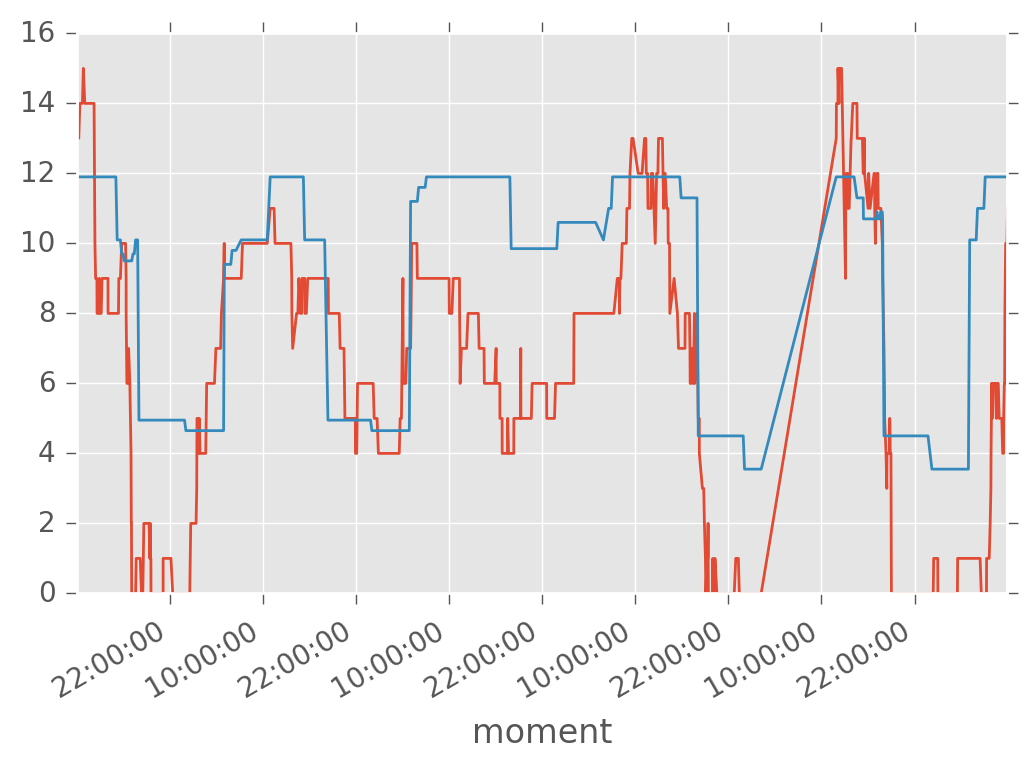

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
plt.style.use('ggplot')

y_test.plot()
y_pred.plot()